In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate

In [3]:
df = pd.read_csv('Final Fashion Dataset.csv')

In [4]:
df.head()

,user_id,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename,link,ratings,review,Month,Price (USD)
0,93810,8493,Women,Apparel,Bottomwear,Skirts,Black,Fall,2011.0,Casual,Forever New Women Black Skirts,8493.jpg,http://assets.myntassets.com/v1/images/style/p...,5,Amazing quality! Definitely recommend. Would r...,November,46
1,24592,30757,Men,Apparel,Topwear,Kurtas,Grey,Summer,2012.0,Ethnic,Fabindia Men Grey Mangalgiri Kurta,30757.jpg,http://assets.myntassets.com/v1/images/style/p...,4,"Perfect for any occasion, great buy..",September,29
2,13278,14881,Women,Accessories,Bags,Handbags,Black,Summer,2011.0,Casual,United Colors of Benetton Women Solid Black Ha...,14881.jpg,http://assets.myntassets.com/v1/images/style/p...,3,"It's okay, nothing special.!",October,39
3,46048,48449,Men,Apparel,Topwear,Tshirts,Blue,Summer,2012.0,Casual,French Connection Men Blue T-shirt,48449.jpg,http://assets.myntassets.com/v1/images/style/p...,5,"Comfortable and stylish, worth the price. and ...",August,39
4,42098,4697,Unisex,Accessories,Watches,Watches,Black,Winter,2016.0,Sports,ADIDAS Unisex Digital Duramo Black Watch,4697.jpg,http://assets.myntassets.com/v1/images/style/p...,4,"Perfect for any occasion, great buy.!",March,33


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36484 entries, 0 to 36483
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             36484 non-null  int64  
 1   id                  36484 non-null  int64  
 2   gender              36484 non-null  object 
 3   masterCategory      36484 non-null  object 
 4   subCategory         36484 non-null  object 
 5   articleType         36484 non-null  object 
 6   baseColour          36484 non-null  object 
 7   season              36484 non-null  object 
 8   year                36484 non-null  float64
 9   usage               36484 non-null  object 
 10  productDisplayName  36484 non-null  object 
 11  filename            36484 non-null  object 
 12  link                36484 non-null  object 
 13  ratings             36484 non-null  int64  
 14  review              36484 non-null  object 
 15  Month               36484 non-null  object 
 16  Pric

In [6]:
df.shape

(36484, 17)

In [7]:
# Encode categorical columns
label_encoders = {}
for column in ['masterCategory', 'subCategory', 'articleType', 'gender', 'baseColour', 'season', 'usage']:
    le = LabelEncoder()
    df[f'{column}_encoded'] = le.fit_transform(df[column])
    label_encoders[column] = le

In [8]:
df.head()

,user_id,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,...,review,Month,Price (USD),masterCategory_encoded,subCategory_encoded,articleType_encoded,gender_encoded,baseColour_encoded,season_encoded,usage_encoded
0,93810,8493,Women,Apparel,Bottomwear,Skirts,Black,Fall,2011.0,Casual,...,Amazing quality! Definitely recommend. Would r...,November,46,1,2,53,4,1,0,0
1,24592,30757,Men,Apparel,Topwear,Kurtas,Grey,Summer,2012.0,Ethnic,...,"Perfect for any occasion, great buy..",September,29,1,10,25,2,13,2,1
2,13278,14881,Women,Accessories,Bags,Handbags,Black,Summer,2011.0,Casual,...,"It's okay, nothing special.!",October,39,0,0,19,4,1,2,0
3,46048,48449,Men,Apparel,Topwear,Tshirts,Blue,Summer,2012.0,Casual,...,"Comfortable and stylish, worth the price. and ...",August,39,1,10,71,2,2,2,0
4,42098,4697,Unisex,Accessories,Watches,Watches,Black,Winter,2016.0,Sports,...,"Perfect for any occasion, great buy.!",March,33,0,12,76,3,1,3,5


In [10]:
complementary_map = {
    'Topwear': ['Bottomwear', 'Shoes', 'Jewellery', 'Eyewear', 'Belts', 'Bags', 'Watches', 'Wallets'],
    'Bottomwear': ['Topwear', 'Shoes', 'Bags', 'Belts', 'Watches', 'Wallets'],
    'Bags': ['Topwear', 'Bottomwear', 'Shoes', 'Watches', 'Jewellery', 'Eyewear'],
    'Watches': ['Topwear', 'Bottomwear', 'Bags', 'Shoes', 'Jewellery'],
    'Shoes': ['Topwear', 'Bottomwear', 'Socks', 'Eyewear', 'Belts'],
    'Flip Flops': ['Topwear', 'Bottomwear', 'Socks', 'Belts', 'Eyewear'],
    'Jewellery': ['Topwear', 'Saree', 'Watches', 'Eyewear'],
    'Eyewear': ['Topwear', 'Bottomwear', 'Shoes', 'Jewellery'],
    'Belts': ['Topwear', 'Bottomwear', 'Shoes', 'Watches'],
    'Saree': ['Jewellery', 'Bags', 'Shoes'],
    'Loungewear and Nightwear': ['Bottomwear', 'Socks'],
    'Wallets': ['Topwear', 'Bottomwear', 'Bags', 'Watches'],
    'Socks': ['Shoes','Loungewear and Nightwear']
}

In [11]:
num_masterCategory = len(df['masterCategory'].unique())
num_subCategory = len(df['subCategory'].unique())
num_articleType = len(df['articleType'].unique())
num_gender = len(df['gender'].unique())
num_baseColour = len(df['baseColour'].unique())
num_season = len(df['season'].unique())
num_usage = len(df['usage'].unique())

In [12]:
print(f"Number of unique master categories: {num_masterCategory}")
print(f"Number of unique sub categories: {num_subCategory}")
print(f"Number of unique article types: {num_articleType}")
print(f"Number of unique genders: {num_gender}")
print(f"Number of unique base colours: {num_baseColour}")
print(f"Number of unique seasons: {num_season}")
print(f"Number of unique usages: {num_usage}")

Number of unique master categories: 3
Number of unique sub categories: 13
Number of unique article types: 77
Number of unique genders: 5
Number of unique base colours: 45
Number of unique seasons: 4
Number of unique usages: 7


In [13]:
from tensorflow.keras.layers import Dot

In [14]:
def create_complementary_model(num_categories, num_gender, num_colors, num_seasons, num_usage, embedding_dim=10):
    # Inputs
    input_masterCategory = Input(shape=(1,), name='masterCategory')
    input_subCategory = Input(shape=(1,), name='subCategory')
    input_articleType = Input(shape=(1,), name='articleType')
    input_gender = Input(shape=(1,), name='gender')
    input_baseColour = Input(shape=(1,), name='baseColour')
    input_season = Input(shape=(1,), name='season')
    input_usage = Input(shape=(1,), name='usage')
    input_price = Input(shape=(1,), name='Price (USD)')

    # Embedding layers for categorical features
    masterCategory_embedding = Embedding(input_dim=num_masterCategory + 1, output_dim=embedding_dim)(input_masterCategory)
    subCategory_embedding = Embedding(input_dim=num_subCategory + 1, output_dim=embedding_dim)(input_subCategory)
    articleType_embedding = Embedding(input_dim=num_articleType + 1, output_dim=embedding_dim)(input_articleType)
    gender_embedding = Embedding(input_dim=num_gender + 1, output_dim=4)(input_gender)
    baseColour_embedding = Embedding(input_dim=num_baseColour + 1, output_dim=45)(input_baseColour)
    season_embedding = Embedding(input_dim=num_season + 1, output_dim=4)(input_season)
    usage_embedding = Embedding(input_dim=num_usage + 1, output_dim=7)(input_usage)

    # Flatten embeddings
    masterCategory_flat = Flatten()(masterCategory_embedding)
    subCategory_flat = Flatten()(subCategory_embedding)
    articleType_flat = Flatten()(articleType_embedding)
    gender_flat = Flatten()(gender_embedding)
    baseColour_flat = Flatten()(baseColour_embedding)
    season_flat = Flatten()(season_embedding)
    usage_flat = Flatten()(usage_embedding)

    # Concatenate all features
    concat = Concatenate()([
        masterCategory_flat, subCategory_flat, articleType_flat,
        gender_flat, baseColour_flat, season_flat, usage_flat, input_price
    ])

    # Dense layers
    dense1 = Dense(128, activation='relu')(concat)
    dense2 = Dense(64, activation='relu')(dense1)

    # Output layer with one node per subCategory (complementary recommendation output)
    complementary_output = Dense(len(df['subCategory_encoded'].unique()), activation='sigmoid', name='complementary')(dense2)

    # Model
    model = Model(inputs=[
        input_masterCategory, input_subCategory, input_articleType,
        input_gender, input_baseColour, input_season, input_usage, input_price
    ], outputs=[complementary_output])

    return model

# Initialize model
model = create_complementary_model(
    num_categories=len(df['subCategory_encoded'].unique()),
    num_gender=len(df['gender_encoded'].unique()),
    num_colors=len(df['baseColour_encoded'].unique()),
    num_seasons=len(df['season_encoded'].unique()),
    num_usage=len(df['usage_encoded'].unique())
)


In [15]:
model.compile(optimizer='adam', loss='binary_crossentropy')

In [18]:
# Generate training pairs and labels based on complementary relationships
def generate_training_pairs(df, complementary_map, label_encoders):
    pairs = []
    labels = []

    for _, row in df.iterrows():
        main_subCategory = row['subCategory']
        main_subCategory_encoded = row['subCategory_encoded']

        if main_subCategory in complementary_map:
            for comp_subCategory in complementary_map[main_subCategory]:
                if comp_subCategory in label_encoders['subCategory'].classes_:
                    comp_subCategory_encoded = label_encoders['subCategory'].transform([comp_subCategory])[0]

                    # Add pair (main item, complementary item)
                    pairs.append([
                        row['masterCategory_encoded'], row['subCategory_encoded'], row['articleType_encoded'],
                        row['gender_encoded'], row['baseColour_encoded'], row['season_encoded'],
                        row['usage_encoded'], row['Price (USD)']
                    ])
                    # Set binary labels for complementary categories (one-hot encoded style)
                    label = np.zeros(len(df['subCategory_encoded'].unique()))
                    label[comp_subCategory_encoded] = 1
                    labels.append(label)

    return np.array(pairs), np.array(labels)

In [19]:
# Generate training pairs and labels
X_train, y_train = generate_training_pairs(df, complementary_map, label_encoders)

In [20]:
# Check shapes of X_train columns and y_train
for i in range(X_train.shape[1]):
    print(f"X_train[:, {i}] shape: {X_train[:, i].shape}, dtype: {X_train[:, i].dtype}")

print(f"y_train shape: {y_train.shape}, dtype: {y_train.dtype}")

X_train[:, 0] shape: (225204,), dtype: int32
X_train[:, 1] shape: (225204,), dtype: int32
X_train[:, 2] shape: (225204,), dtype: int32
X_train[:, 3] shape: (225204,), dtype: int32
X_train[:, 4] shape: (225204,), dtype: int32
X_train[:, 5] shape: (225204,), dtype: int32
X_train[:, 6] shape: (225204,), dtype: int32
X_train[:, 7] shape: (225204,), dtype: int32
y_train shape: (225204, 13), dtype: float64


In [22]:
# Convert X_train to int32
X_train = X_train.astype('int32')

# Convert y_train to float32
y_train = y_train.astype('float32')

In [23]:
# Train the model
model.fit([
    X_train[:, 0], X_train[:, 1], X_train[:, 2], X_train[:, 3],
    X_train[:, 4], X_train[:, 5], X_train[:, 6], X_train[:, 7]
], y_train, epochs=10, batch_size=32)

Epoch 1/10


c:\Users\Chait\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['masterCategory', 'subCategory', 'articleType', 'gender', 'baseColour', 'season', 'usage', 'Price (USD)']. Received: the structure of inputs=('*', '*', '*', '*', '*', '*', '*', '*')
  warnings.warn(


7038/7038 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.2371
Epoch 2/10
7038/7038 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.2151
Epoch 3/10
7038/7038 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.2143
Epoch 4/10
7038/7038 ━━━━━━━━━━━━━━━━━━━━ 7s 994us/step - loss: 0.2142
Epoch 5/10
7038/7038 ━━━━━━━━━━━━━━━━━━━━ 7s 987us/step - loss: 0.2139
Epoch 6/10
7038/7038 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.2139
Epoch 7/10
7038/7038 ━━━━━━━━━━━━━━━━━━━━ 7s 968us/step - loss: 0.2137
Epoch 8/10
7038/7038 ━━━━━━━━━━━━━━━━━━━━ 7s 998us/step - loss: 0.2138
Epoch 9/10
7038/7038 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.2136
Epoch 10/10
7038/7038 ━━━━━━━━━━━━━━━━━━━━ 7s 973us/step - loss: 0.2137


In [24]:
def recommend_complementary_with_ids(item_id, df, model, label_encoders):
    # Get the original item details
    item = df[df['id'] == item_id].iloc[0]

    # Prepare input for the model
    input_data = [
        np.array([item['masterCategory_encoded']]),
        np.array([item['subCategory_encoded']]),
        np.array([item['articleType_encoded']]),
        np.array([item['gender_encoded']]),
        np.array([item['baseColour_encoded']]),
        np.array([item['season_encoded']]),
        np.array([item['usage_encoded']]),
        np.array([item['Price (USD)']])
    ]

    # Get model predictions for complementary subcategories
    predictions = model.predict(input_data)[0]
    top_complementary_indices = predictions.argsort()[-3:][::-1]
    complementary_subCategories = [label_encoders['subCategory'].inverse_transform([i])[0] for i in top_complementary_indices]

    recommendations = []

    # Find a sample product ID for each complementary subcategory
    for subCategory in complementary_subCategories:
        # Filter dataset for items matching the complementary subcategory and other features
        complementary_items = df[
            (df['subCategory'] == subCategory) &
            (df['gender'] == item['gender']) &
            (df['season'] == item['season']) &
            (df['usage'] == item['usage'])
        ]

        # Get a sample product ID from the filtered complementary items
        if not complementary_items.empty:
            sample_item = complementary_items.sample(1).iloc[0]
            recommendations.append((subCategory, sample_item['id']))
        else:
            recommendations.append((subCategory, None))  # No match found, return None for ID

    return recommendations


In [41]:
import random

def get_product_details(item_id, df):
    item = df[df['id'] == item_id]
    if not item.empty:
        return item.iloc[0]
    else:
        return None

# Loop through random items from the dataset
for _ in range(10):  # Change the range to the desired number of random items
  random_item_id = random.choice(df['id'].values)
  product_details = get_product_details(random_item_id, df)
  
  if product_details is not None:
    print(f"Details for product ID {random_item_id}:")
    print(product_details)
    recommendations = recommend_complementary_with_ids(random_item_id, df, model, label_encoders)
    print(f"Recommended complementary items for product ID {random_item_id}: {recommendations}")
  else:
    print(f"Product with ID {random_item_id} not found in the dataset.")


Details for product ID 47069:
user_id                                                               85372
id                                                                    47069
gender                                                                Women
masterCategory                                                      Apparel
subCategory                                                      Bottomwear
articleType                                                         Patiala
baseColour                                                        Navy Blue
season                                                                 Fall
year                                                                 2012.0
usage                                                                Ethnic
productDisplayName                 Shree Women Navy Blue & Lavender Patiala
filename                                                          47069.jpg
link                      http://assets.myntassets.com/v1/

In [43]:
import random

# Loop through random items from the dataset
for _ in range(10):  # Change the range to the desired number of random items
    random_item_id = random.choice(df['id'].values)
    recommendations = recommend_complementary_with_ids(random_item_id, df, model, label_encoders)
    print(f"Recommended complementary items for product ID {random_item_id}: {recommendations}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Recommended complementary items for product ID 42998: [('Topwear', 19006), ('Bottomwear', 49654), ('Socks', 7680)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Recommended complementary items for product ID 41254: [('Bottomwear', 53747), ('Shoes', 44779), ('Topwear', 6059)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Recommended complementary items for product ID 19284: [('Bottomwear', 43523), ('Topwear', 21418), ('Shoes', 43927)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Recommended complementary items for product ID 25004: [('Bottomwear', 30442), ('Eyewear', 30274), ('Shoes', 26637)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Recommended complementary items for product ID 35185: [('Bottomwear', None), ('Shoes', 23793), ('Eyewear', None)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Recommended complementary items for product ID 9063: [('Bottomwear', 13782), ('Eyewear', None), ('Shoes', 57488)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Recommended complementary items for product 

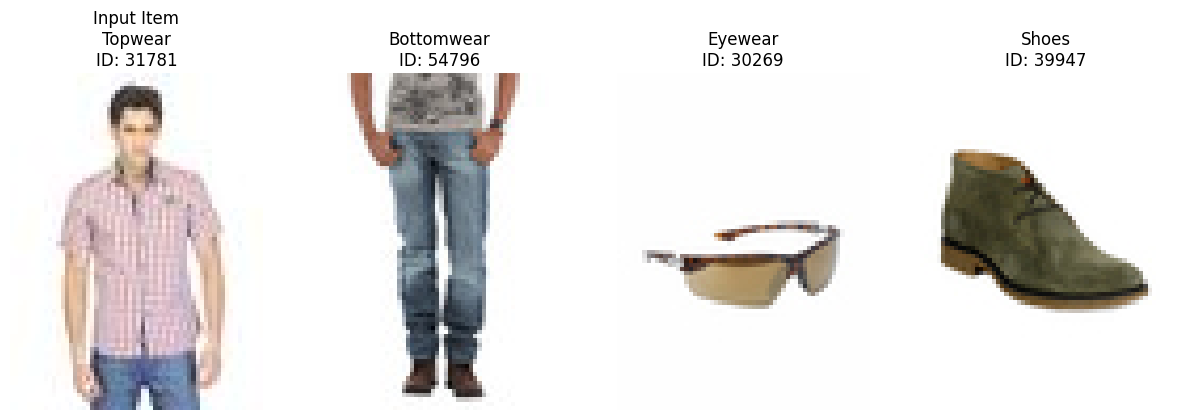

In [49]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_images_for_recommendations(item_id, recommendations, df):
    # Get the input item details
    input_item = df[df['id'] == item_id].iloc[0]
    input_img_path = f"images/images/{input_item['filename']}"

    # Create a subplot with 1 + len(recommendations) columns
    fig, axes = plt.subplots(1, len(recommendations) + 1, figsize=(15, 5))

    # Display the input item image
    input_img = mpimg.imread(input_img_path)
    axes[0].imshow(input_img)
    axes[0].set_title(f"Input Item\n{input_item['subCategory']}\nID: {item_id}")
    axes[0].axis('off')

    # Display the recommended items images
    for i, (subcategory, rec_id) in enumerate(recommendations):
        if rec_id is not None:
            rec_item = df[df['id'] == rec_id].iloc[0]
            rec_img_path = f"images/images/{rec_item['filename']}"
            rec_img = mpimg.imread(rec_img_path)
            axes[i + 1].imshow(rec_img)
            axes[i + 1].set_title(f"{subcategory}\nID: {rec_id}")
        else:
            axes[i + 1].text(0.5, 0.5, 'No Image', horizontalalignment='center', verticalalignment='center')
            axes[i + 1].set_title(f"{subcategory}\n(No Image)")
        axes[i + 1].axis('off')

    plt.show()

# Example usage
show_images_for_recommendations(item_id, recommendations, df)